# EECE-5554 Final Project: Ground Truth Analysis

This notebook uses data collected from the NUANCE car driving around the city of Boston, MA. We plot the trajectory and some other characteristics in order to have a point of comparison for the map we will be creating using Visual SLAM.

Using the rosbag from the car, we can extract from this a .csv file for each topic that we can use for our data analysis. From within the same directory as the rosbag, run:
 - `rostopic echo -b <FILENAME>.bag -p /imu/imu > pathX_imu.csv`
 - `rostopic echo -b <FILENAME>.bag -p /vehicle/gps/fix > pathX_gps.csv`

We are now ready for the analysis. We'll use the stamped time to sync all messages, rather than the published time in the `%time` field. Note that for this data, GPS data comes in at 1Hz, while IMU/Mag data comes in much more frequently, so there is not a direct association for all three messages at every timestep.

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import utm
from scipy.spatial.transform import Rotation as R
import scipy.stats as stats

# globally disable plots automatically using an offset.
plt.rcParams['axes.formatter.useoffset'] = False
# lower title size on all plots.
plt.rcParams.update({'axes.titlesize': 'small'})

We have two datasets, labelled with the notation "path1" and "path2". The "path1" dataset was provided to us, and the "path2" dataset we collected ourselves; both come from the NUANCE car. The parameter `FILE_ID` sets which dataset will be used. IMU plots can be hidden by setting `SHOW_IMU_PLOTS` to False. Plots will be saved to the `plots` directory if the `SAVE_PLOTS` flag is set.

In [29]:
FILE_ID = "path1" # options: "path1", "path2"
SAVE_PLOTS = False
SHOW_IMU_PLOTS = True

We extract the relevant columns, excluding the covariances of several parameters. The GPS frame is of a different size, and is already limited to only useful columns.

In [30]:
# Read in all three data files.
imu_df = pd.read_csv("./data/"+FILE_ID+"_imu.csv", header=0)
gps_df = pd.read_csv("./data/"+FILE_ID+"_gps.csv", header=0)

# Setup IMU dataframe.
# imu_df = imu_df[["field.header.stamp","field.orientation.w","field.orientation.x",
#                  "field.orientation.y","field.orientation.z","field.angular_velocity.x",
#                  "field.angular_velocity.y","field.angular_velocity.z","field.linear_acceleration.x",
#                  "field.linear_acceleration.y","field.linear_acceleration.z"]]
# create a column for time since start, called "time".
start_time = float(imu_df["field.header.stamp"][0])
imu_df["time"] = (imu_df["field.header.stamp"] - start_time) / (10**9) # nano to seconds.
# create a column for time difference between consecutive measurements, called "dt".
dt_list = [0]
for i in range(1,len(imu_df["time"])):
    dt_list.append(imu_df["time"][i] - imu_df["time"][i-1])
imu_df["dt"] = dt_list
# convert quaternion to raw YPR Euler angles provided by the IMU. (all radians)
y_list, p_list, r_list = [], [], []
for i in range(len(imu_df["field.orientation.w"])):
    q = [imu_df["field.orientation.w"][i], imu_df["field.orientation.x"][i], imu_df["field.orientation.y"][i], imu_df["field.orientation.z"][i]]
    y, p, r = R.from_quat(q).as_euler('zyx')
    y_list.append(y); p_list.append(p); r_list.append(r)
imu_df["yaw"] = y_list
imu_df["pitch"] = p_list
imu_df["roll"] = r_list


# Setup GPS dataframe.
# create a column for time since start, called "time".
start_time = float(gps_df["field.header.stamp"][0])
gps_df["time"] = (gps_df["field.header.stamp"] - start_time) / (10**9) # nano to seconds.
# create a column for time difference between consecutive measurements, called "dt".
dt_list = [0]
for i in range(1,len(gps_df["time"])):
    dt_list.append(gps_df["time"][i] - gps_df["time"][i-1])
gps_df["dt"] = dt_list
# convert GPS lat/lon to UTM meters.
utm_easting = []; utm_northing = []; utm_zone = []; utm_letter = []
for i in range(len(gps_df["time"])):
    utm_vals = utm.from_latlon(gps_df["field.latitude"][i], gps_df["field.longitude"][i])
    utm_easting.append(utm_vals[0])
    utm_northing.append(utm_vals[1])
    utm_zone.append(utm_vals[2])
    utm_letter.append(utm_vals[3])
gps_df["field.utm_easting"] = utm_easting
gps_df["field.utm_northing"] = utm_northing
gps_df["field.utm_zone"] = utm_zone
gps_df["field.utm_letter"] = utm_letter
# create columns for meters relative to start.
start_utm_easting = float(gps_df["field.utm_easting"][0])
gps_df["easting_rel"] = (gps_df["field.utm_easting"] - start_utm_easting)
start_utm_northing = float(gps_df["field.utm_northing"][0])
gps_df["northing_rel"] = (gps_df["field.utm_northing"] - start_utm_northing)

# Print dataframe sizes.
print("Setup imu_df with " + str(imu_df.shape[0]) + " points.")
print("Setup gps_df with " + str(gps_df.shape[0]) + " points.")

Setup imu_df with 60237 points.
Setup gps_df with 597 points.


We now have our data loaded in and setup as two dataframes, `imu_df` and `gps_df`. 

We define functions that will be used for multiple data fields.

In [31]:
def make_multiplot(FILE_ID:str, df, x:str="time", y:str="",y1=".x",y2=".y",y3=".z", title:str=""):
    """
    Create a plot with multiple subplots of given data columns.
    @param FILE_ID: the unique file identifier for the dataset in question.
    @param df: a pandas dataframe of the GPS data.
    @param x: the str key for data column to use as x on plot.
    @param y: the str key for data column to use as y on plot.
    @param y1, y2, y3: the subfields of the main data being plotted.
    @param title: optional title for plot if default is not desired.
    """
    # make var name less verbose.
    y_concise = {"" : "orientation", "field.angular_velocity" : "ang_vel", 
                 "field.linear_acceleration" : "accel", "field.magnetic_field" : "mag"}
    y_title = y if y not in y_concise else y_concise[y]
    # make all subplots.
    fig, axs = plt.subplots(3, sharex=True)
    fig.suptitle((title if title != "" else FILE_ID))
    axs[0].grid(True) # show gridlines
    axs[0].scatter(x, y+y1, data=df, s=1)
    axs[0].set(ylabel=y1 if "." not in y1 else y1[1:])
    axs[1].grid(True)
    axs[1].scatter(x, y+y2, data=df, s=1)
    axs[1].set(ylabel=y2 if "." not in y2 else y2[1:])
    axs[2].grid(True)
    axs[2].scatter(x, y+y3, data=df, s=1)
    axs[2].set(xlabel="Time (s)", ylabel=y3 if "." not in y3 else y3[1:])
#     plt.tight_layout()
    # save to a file in plots/ directory.
    if SAVE_PLOTS:
        plt.savefig("./plots/"+FILE_ID+"_"+y_title+".png", format='png')
    # show plot.
    plt.show()

In [32]:
def make_plot(FILE_ID:str, df, x:str, y:str, title:str="", show_distr=False):
    """
    Create a plot with only one field, instead of the multiplot's three.
    @param FILE_ID: the unique file identifier for the dataset in question.
    @param df: a pandas dataframe.
    @param x: the str key for data column to use as x on plot.
    @param y: the str key for data column to use as y on plot.
    @param title: optional title for plot if default is not desired.
    @param show_distr: flag to enable midline and gaussian plot.
    """
    # ignore the first point if this is dt, since it is 0 and throws off the plot scale.
    if y == "dt":
        df = df.iloc[1: , :]
    # do the plotting.
    sns.set_context("talk", font_scale=1.1)
    plt.figure() #figsize=(8,7)
    plt.grid(True)
    sns.scatterplot(x=x, y=y, data=df, palette='colorblind',s=10,linewidth=0,zorder=2)
    # compute gaussian statistics, show midline at mean.
    mu, sigma = stats.norm.fit(df[y])
    if show_distr:
        plt.hlines(y=mu, color='r', linestyle='-', xmin=min(df["time"]), xmax=max(df["time"]))
    stats_ = y+" Mean: " + str(mu)+"\n" + y+" Standard Deviation: " + str(sigma)+"\n"
#     print(stats_)
    # other plot formatting.
    plt.xlabel(x + (" (s)" if x == "time" else " (m)"))
    plt.ylabel(y + (" (ms)" if y == "dt" else " (m)"))
    plt.title((title if title != "" else FILE_ID))
#     plt.tight_layout()
    # save to a file in plots/ directory.
    if SAVE_PLOTS:
        plt.savefig("./plots/"+FILE_ID+"_"+y+"_vs_"+x+".png", format='png')
    # show the plot.
    plt.show()

Now we can use these functions to plot all multivariate columns, namely the linear accleration, angular velocity, and magnetic field, which each have x, y, and z components. We can also use this to ploy yaw, pitch, and roll.

We can also plot single-variable graphs, namely dt and GPS position.

All lines are commented out since it produces a lot of plots. Uncomment any or all lines to see the results.

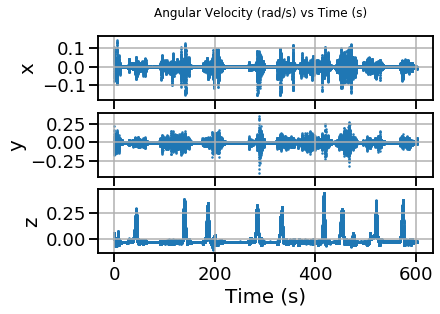

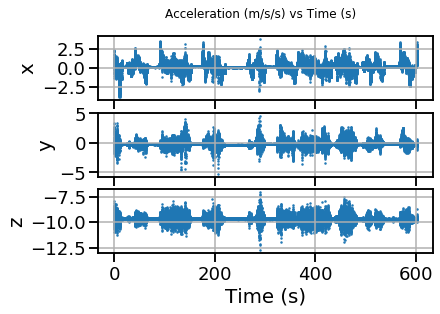

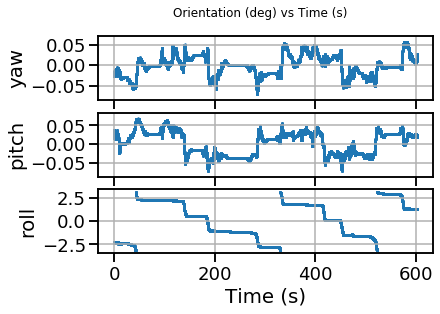

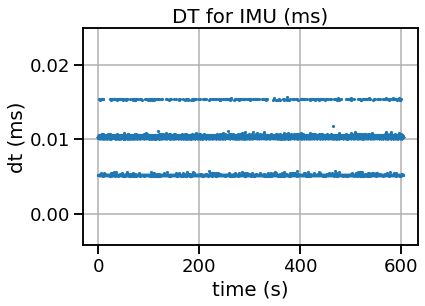

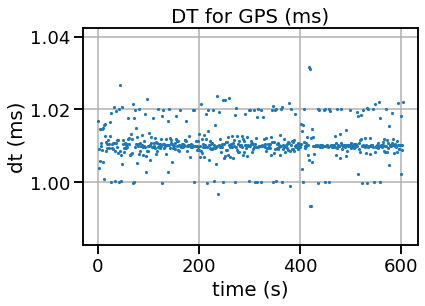

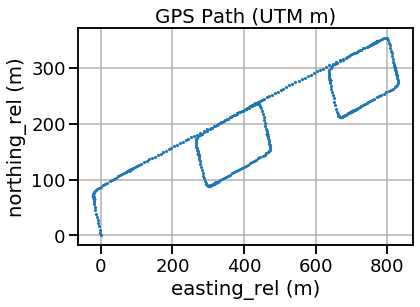

In [33]:
if SHOW_IMU_PLOTS:
    make_multiplot(FILE_ID,imu_df,x="time",y="field.angular_velocity",title="Angular Velocity (rad/s) vs Time (s)")
    make_multiplot(FILE_ID,imu_df,x="time",y="field.linear_acceleration",title="Acceleration (m/s/s) vs Time (s)")
    make_multiplot(FILE_ID,imu_df,x="time",y1="yaw",y2="pitch",y3="roll",title="Orientation (deg) vs Time (s)")
    make_plot(FILE_ID+"_imu",imu_df,x="time",y="dt",title="DT for IMU (ms)")
    make_plot(FILE_ID+"_gps",gps_df,x="time",y="dt",title="DT for GPS (ms)")
# plot the GPS path.
make_plot(FILE_ID,gps_df,x="easting_rel",y="northing_rel",title="GPS Path (UTM m)")